In [1]:
import pandas as pd
import sklearn
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model

import matplotlib.lines as mlinesZ
import json
import datetime
import time
import os
import warnings
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, scale
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight
plt.style.use('seaborn-deep')

# Use this line to enable GPU (only on applicable architecures)
# get_ipython().run_line_magic('env', 'CUDA_DEVICE_ORDER=PCI_BUS_ID')
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # turns off gpu
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)


In [5]:
# Load tracks from stored pickle of ntuples
df = pd.read_pickle('/data/newhouse/LRT/batch/master/training/tracks.pkl')

In [6]:
# Inspect loaded dataframe
print("columns:", df.columns)
print("Total number of tracks loaded", len(df))
df.describe()

columns: Index(['numberOfPixelHoles', 'numberOfSCTHoles', 'numberOfSCTDoubleHoles',
       'numberOfContribPixelLayers', 'numberOfBLayerHits',
       'numberOfGangedFlaggedFakes', 'numberOfPixelHits', 'numberOfSCTHits',
       'standardDeviationOfChi2OS', 'track_pt', 'chiSquared', 'numberDoF',
       'numberOfBLayerSplitHits', 'numberOfInnermostLayerSplitHits',
       'numberOfInnermostPixelLayerHits',
       'numberOfNextToInnermostLayerSplitHits',
       'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelSplitHits',
       'numberOfPixelOutliers', 'numberOfSCTOutliers',
       'numberOfPixelSpoiltHits', 'numberOfSCTSpoiltHits',
       'numberOfGangedPixels', 'numberOfOutliersOnTrack', 'eta', 'd0', 'z0',
       'phi0', 'theta', 'qOverP', 'score', 'linkValid', 'truthProbability',
       'signal', 'geometric_var', 'abs_z0', 'abs_d0', 'abs_eta', 'Sihits',
       'is_good'],
      dtype='object')
Total number of tracks loaded 2038773


,numberOfPixelHoles,numberOfSCTHoles,numberOfSCTDoubleHoles,numberOfContribPixelLayers,numberOfBLayerHits,numberOfGangedFlaggedFakes,numberOfPixelHits,numberOfSCTHits,standardDeviationOfChi2OS,track_pt,...,phi0,theta,qOverP,score,truthProbability,geometric_var,abs_z0,abs_d0,abs_eta,Sihits
count,2.038773e+06,2.038773e+06,2038773.0,2.038773e+06,2038773.0,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,...,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06,2.038773e+06
mean,2.398379e-01,3.475610e-01,0.0,9.511250e-01,-1.0,1.945680e-02,9.830006e-01,7.700646e+00,1.266096e+02,3.995864e+04,...,-2.402670e-02,1.566881e+00,1.809319e-05,1.932101e+02,6.641379e-01,1.294404e+00,1.828915e+02,6.395222e+01,1.134300e+00,8.683647e+00
std,4.269845e-01,4.761958e-01,0.0,8.904010e-01,0.0,1.391712e-01,9.620167e-01,9.611489e-01,4.759140e+03,4.638887e+07,...,1.815492e+00,9.394522e-01,4.290151e-04,1.796679e+03,2.405604e-01,9.074623e-01,1.358893e+02,5.846908e+01,6.735796e-01,1.205982e+00
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,2.000000e+00,-1.000000e+00,1.000001e+03,...,-3.141592e+00,1.348850e-01,-9.998488e-04,7.758226e-05,1.000000e-01,4.063888e-07,3.377415e-05,7.760171e-06,3.486286e-06,6.000000e+00
25%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,7.000000e+00,5.300000e+01,1.190887e+03,...,-1.594867e+00,6.294361e-01,-2.974904e-04,8.081034e-03,5.000000e-01,4.284436e-01,6.103350e+01,1.614643e+01,5.752195e-01,8.000000e+00
50%,0.000000e+00,0.000000e+00,0.0,1.000000e+00,-1.0,0.000000e+00,1.000000e+00,8.000000e+00,9.000000e+01,1.525787e+03,...,-3.311657e-02,1.565139e+00,3.227290e-05,1.577339e-02,6.666667e-01,1.181247e+00,1.576559e+02,4.588084e+01,1.116142e+00,8.000000e+00
75%,0.000000e+00,1.000000e+00,0.0,1.000000e+00,-1.0,0.000000e+00,1.000000e+00,8.000000e+00,1.480000e+02,2.528917e+03,...,1.542515e+00,2.505005e+00,3.316742e-04,6.362113e-02,8.750000e-01,2.164172e+00,2.898358e+02,9.572634e+01,1.616582e+00,9.000000e+00
max,1.000000e+00,1.000000e+00,0.0,6.000000e+00,-1.0,3.000000e+00,9.000000e+00,1.800000e+01,3.189489e+06,6.623324e+10,...,3.141591e+00,3.006237e+00,9.997356e-04,1.096304e+06,1.000000e+00,3.002888e+00,4.999996e+02,2.998766e+02,2.694963e+00,2.100000e+01


# Balancing classes
In this section I will balance the classes so there are equal numbers of each.

First let's take a look at what the classes look like unbalanced

In [14]:
good = df[df['is_good']]
fake = df[df['is_good']==False]

In [15]:
plot_options = {
    'histtype' : 'step',
    'linewidth' : 3.5, 
    'alpha' : 0.85, 
    'density' : None,
    'bins' : np.linspace(0,1,11)
}

def plot_truth_prob(good, fake, var='truthProbability'):
    good_vals = ax.hist(good[var], edgecolor='#4C72B0', **plot_options)
    fake_vals = ax.hist(fake[var], edgecolor='#55A868', **plot_options)
    ax.legend(['fake', 'good'], loc='upper left', fontsize=20)
    ax.set_xlabel(var, fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=16)
    return ax

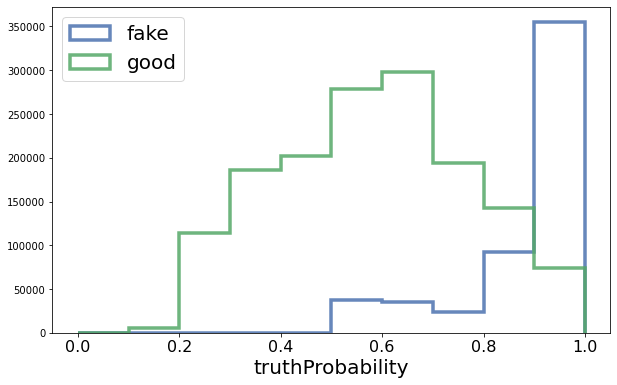

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(10,6))

plot_truth_prob(good, fake)

# Upsampling Classes
This balances the classes by subsampling the same number of true and fake tracks. This is to prevent the network from learning to prefer one class over the other.

#### I've found other upsampling implementations lose information by using replacement. This is my own implementation.

In [17]:
def upsample(df_true, df_false):
    # I've found other upsampling implementations lose information by using replacement
    # how much bigger?
    if len(df_true) < len(df_false):
        majority = df_false
        minority = df_true
    else:
        majority = df_true
        minority = df_false
        
    print('upsampling')
    ratio_floor = int(np.floor(len(majority)/len(minority)))
    remainder = len(majority) % len(minority)

    temp_df = majority
    
    # append multiplied minority
    temp_df = temp_df.append(
        pd.concat([minority]*ratio_floor, ignore_index=True),
        ignore_index=True)
    
    # append randomly sampled remaining minority
    temp_df = temp_df.append(
        minority.sample(remainder),
        ignore_index=True)
    
    # randomly combined data frame
    return temp_df.sample(frac=1)

def downsample(df_true, df_false):
    initial_len = [len(df_true), len(df_false)]
    sample_len = min(initial_len)
    print('downsampling')
    df_true = df_true.sample(sample_len)
    df_false = df_false.sample(sample_len)

    # Combine and shuffle the true and false dataframes
    return df_true.append(df_false).sample(frac=1)

upsampling
Total sample size 2989648


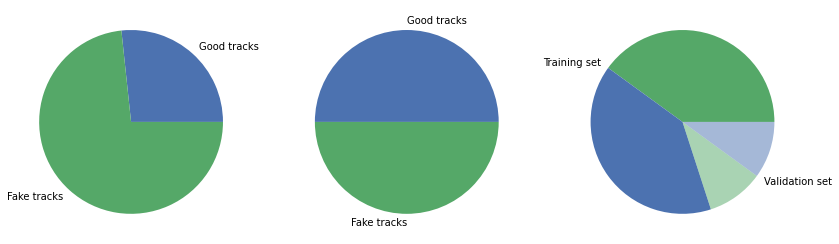

In [19]:
# Combine and shuffle the true and false dataframes
initial_len = [len(good), len(fake)]
df = upsample(good, fake)
good = df[df['is_good']]
fake = df[df['is_good']==False]
good_count = len(good)
fake_count = len(fake)

# Visualize flow in pie charts
fig, (ax0, ax1, ax2) = plt.subplots(1, 3,figsize=(14,6))
print("Total sample size",len(df))
pie1 = ax0.pie(initial_len, labels=["Good tracks", "Fake tracks"])
pie1 = ax1.pie([good_count, fake_count], labels=["Good tracks", "Fake tracks"])
pie2 = ax2.pie([good_count*.4,fake_count*.4,good_count*.1,fake_count*.1], labels=["","","", ""], colors=["#55A868","#4C72B0","#55A868","#4C72B0"])
pie2[0][2].set_alpha(0.5)
pie2[0][3].set_alpha(0.5)
pie2 = ax2.pie([.8,.2], labels=["Training set", "Validation set"], colors=["b","g"], )
pie2[0][0].set_alpha(0.0)
pie2[0][1].set_alpha(0.0)

# Weighting distribution



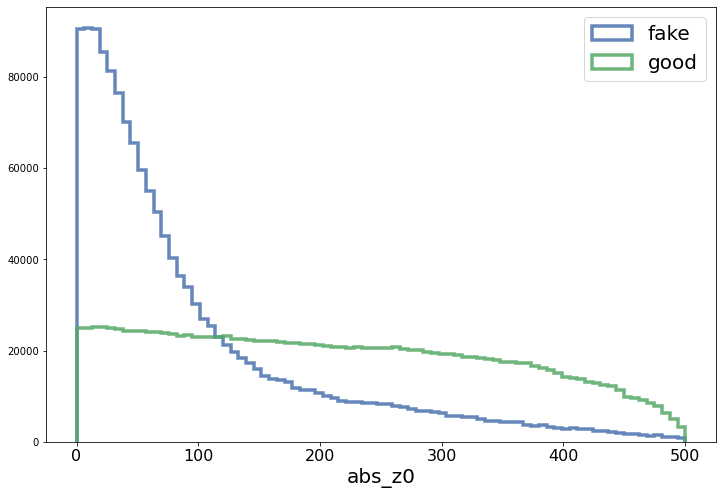

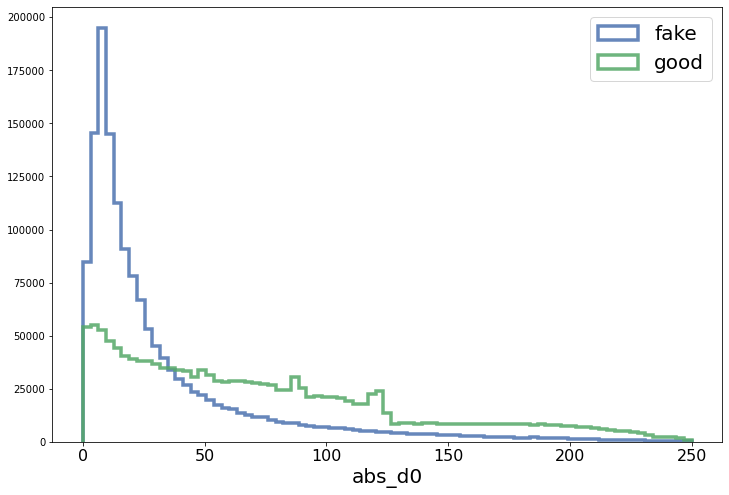

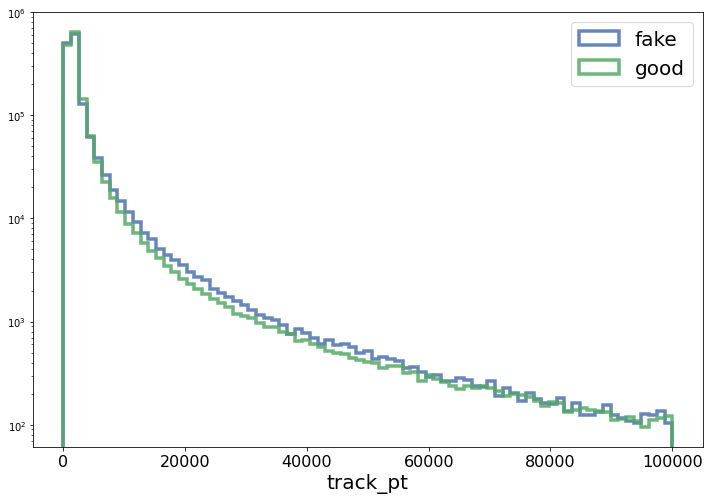

In [24]:
def compare_variable(x, good, fake, bins=np.linspace(0,1,11), leg_loc='upper left', log=False):
    plot_options = {
        'histtype' : 'step',
        'linewidth' : 3.5, 
        'alpha' : 0.85, 
        'density' : None,
        'bins' : bins,
        'log' : log
    }

    good_vals = ax.hist(good[x], edgecolor='#4C72B0', **plot_options)
    fake_vals = ax.hist(fake[x], edgecolor='#55A868', **plot_options)
    ax.legend(['fake', 'good', ], loc=leg_loc, fontsize=20)
    ax.set_xlabel(x, fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=16)
    return ax

fig, ax = plt.subplots(1, 1,figsize=(12,8))
compare_variable('abs_z0', good, fake, bins=np.linspace(0,500,80), leg_loc='upper right')
fig, ax = plt.subplots(1, 1,figsize=(12,8))
compare_variable('abs_d0', good, fake, bins=np.linspace(0,250,80), leg_loc='upper right')
fig, ax = plt.subplots(1, 1,figsize=(12,8))
compare_variable('track_pt', good, fake, bins=np.linspace(0,1e5,80), leg_loc='upper right', log=True)


# Weights
dummy weights for now

In [25]:
df = good.append(fake)

In [28]:
df['weights']=1

# Save to pickle

In [30]:
df.to_pickle('/data/newhouse/LRT/batch/master/training/tracks_weighted.pkl')

# Parking lot of code

In [ ]:
### Weighing tracks by pt
# In this section we weight each track by its inverse histogram weight.
# This can be done after flattening by subsampling.
# The weights will be used in Keras' training to prevent learning the pt distribution of the tracks
# Note: I believe this is important to do after class weighting.

# Define bins and produce histogram
d_pt = 1000; n_bins = 100
bins = np.linspace(0,n_bins*d_pt, n_bins, endpoint=False)
pt_hist, _ = np.histogram(df.track_pt, bins=bins, density=False)

# Guarantee that anything in the highest bin gets a weight of 1. Like a cutoff. Almost all high bins only have a weight of 1
bins[-1] = np.inf
pt_hist[-1] = np.max(pt_hist) # Overflow bin

# Digitize finds which bin each pt value belongs to
pt_bin = np.digitize(df.track_pt, bins)
pt_bin = pt_bin - 1 # indexes from one for some reason (may not understand this fully)

# Define the weights as the inverse of the histogram weights.
# This will give less weight to low-pt tracks since there are many
track_weights = (1/pt_hist[pt_bin])
df['track_weights'] = track_weights

# Sanity check plot. this weighted histogram should be exactly flat.
# Some gaps may appear if no tracks fall in that pt range
ax = df.track_pt.hist(bins=bins, density=False,figsize=(10,7), weights=track_weights)